In [ ]:
#!pip install helical==0.0.1a23
#!pip install scanpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 17.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of gtfparse to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions 

In [1]:
import os
import gdown
from google.colab import files
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import anndata as ad
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from scipy.sparse import lil_matrix
import torch.optim as optim
from helical.models.scgpt.model import scGPT, scGPTConfig
from helical.models.geneformer.model import Geneformer, GeneformerConfig
from copy import deepcopy
from torch.nn.functional import one_hot
import scanpy as sc
import matplotlib.pyplot as plt

from helical.utils import get_anndata_from_hf_dataset
import umap
import seaborn as sns
from datasets import load_dataset

INFO:datasets:PyTorch version 2.5.1 available.
INFO:datasets:Polars version 1.21.0 available.
INFO:datasets:TensorFlow version 2.18.0 available.
INFO:datasets:JAX version 0.5.2 available.
INFO:helical:Caduceus not available: If you want to use this model, ensure you have a CUDA GPU and have installed the optional helical[mamba-ssm] dependencies.


# Datos Helical

In [8]:
ds = load_dataset("helical-ai/yolksac_human",trust_remote_code=True, download_mode="reuse_cache_if_exists")


test_dataset = get_anndata_from_hf_dataset(ds["test"])

sc.pp.highly_variable_genes(test_dataset, n_top_genes=3000, flavor='seurat_v3', inplace=True)
test_dataset = test_dataset[:, test_dataset.var["highly_variable"]]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

# Datos Esclerosis Múltiple

In [2]:
output_dir = "../data/ms"
if os.path.exists(output_dir):

    print("data already downloaded!!")

else:

    folder_id = "1Qd42YNabzyr2pWt9xoY4cVMTAxsNBt4v"
    gdown.download_folder(f"https://drive.google.com/drive/folders/{folder_id}", output=output_dir, quiet=False)


data_enfermos = ad.read_h5ad(f'../data/ms/filtered_ms_adata.h5ad')

Retrieving folder contents


Processing file 1Vp51xYAOEu5_Wd7lilnatvMJ7tr2bsbl .DS_Store
Processing file 1bV1SHKVZgkcL-RmmuN51_IIUJTSJbXOi c_data.h5ad
Processing file 1casFhq4InuBNhJLMnGebzkRXM2UTTeQG filtered_ms_adata.h5ad


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1Vp51xYAOEu5_Wd7lilnatvMJ7tr2bsbl
To: /data/ms/.DS_Store
100%|██████████| 6.15k/6.15k [00:00<00:00, 11.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bV1SHKVZgkcL-RmmuN51_IIUJTSJbXOi
To: /data/ms/c_data.h5ad
100%|██████████| 20.6M/20.6M [00:00<00:00, 74.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1casFhq4InuBNhJLMnGebzkRXM2UTTeQG
To: /data/ms/filtered_ms_adata.h5ad
100%|██████████| 47.1M/47.1M [00:00<00:00, 103MB/s]
Download completed


# Modelos Zero-Shot

## scGPT

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Aplicado a datos de Esclerosis

In [ ]:
scgpt_config = scGPTConfig(batch_size=16, device=device)
scgpt = scGPT(configurer = scgpt_config)
data = scgpt.process_data(data_enfermos, gene_names = "gene_name", use_raw_counts = False) # La tenemos por defecto con ese nombre
x_scgpt = scgpt.get_embeddings(data)

INFO:helical.utils.downloader:Creating Folder /root/.cache/helical/models/scgpt/scGPT_CP
INFO:helical.utils.downloader:File does not exist or has incorrect hash. Starting to download: 'https://helicalpackage.blob.core.windows.net/helicalpackage/data/scgpt/scGPT_CP/vocab.json'
Downloading: 100%|██████████| 1.32M/1.32M [00:00<00:00, 1.57MB/s]
INFO:helical.utils.downloader:File saved to: '/root/.cache/helical/models/scgpt/scGPT_CP/vocab.json'
INFO:helical.utils.downloader:File does not exist or has incorrect hash. Starting to download: 'https://helicalpackage.blob.core.windows.net/helicalpackage/data/scgpt/scGPT_CP/best_model.pt'
Downloading: 100%|██████████| 208M/208M [00:05<00:00, 39.2MB/s]
INFO:helical.utils.downloader:File saved to: '/root/.cache/helical/models/scgpt/scGPT_CP/best_model.pt'
INFO:helical.models.scgpt.model:Model finished initializing.
INFO:helical.models.scgpt.model:'scGPT' model is in 'eval' mode, on device 'cuda' with embedding mode 'cls'.
INFO:helical.models.scgpt.m

## Visualización

In [ ]:
embeddings_scGPT = ad.AnnData(X=x_scgpt)
data_enfermos.obsm["X_scgpt"] = embeddings_scGPT.X

sc.tl.pca(embeddings_scGPT)
data_enfermos.obsm["X_pca"] = embeddings_scGPT.obsm['X_pca']
data_enfermos.uns["pca"] = embeddings_scGPT.uns['pca']

sc.pp.neighbors(embeddings_scGPT, use_rep="X")
sc.tl.umap(embeddings_scGPT, random_state = 0)

data_enfermos.obsm["X_umap"] = embeddings_scGPT.obsm["X_umap"]
data_enfermos.uns["neighbors"] = embeddings_scGPT.uns['neighbors']
data_enfermos.obsp["distances"] = embeddings_scGPT.obsp['distances']
data_enfermos.obsp["connectivities"] = embeddings_scGPT.obsp['connectivities']

sc.tl.tsne(data_enfermos, use_rep = "X_pca", random_state = 0)

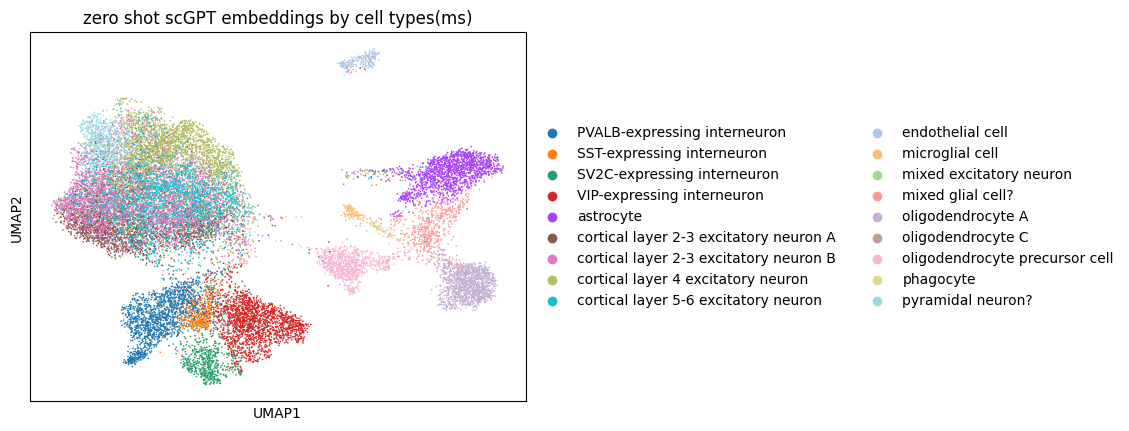

In [ ]:
sc.pl.umap(data_enfermos, color=["celltype"], wspace = 0.6,title = "zero shot scGPT embeddings by cell types(ms)")

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
sc.pl.tsne(data_enfermos, color='celltype', ax=ax1, show=False, title='t-SNE scGPT zero-shot embeddings ms', legend_fontsize=8)
sc.pl.umap(data_enfermos, color='celltype', ax=ax2, show=False, title='UMAP scGPT zero-shot embeddings ms', legend_fontsize=8)

plt.tight_layout()
plt.show()

### Aplicado a datos Helical

In [7]:
scgpt_config = scGPTConfig(batch_size=16, device=device)
scgpt = scGPT(configurer = scgpt_config)
data = scgpt.process_data(test_dataset, gene_names = "gene_name")
x_scgpt = scgpt.get_embeddings(data)

INFO:helical.utils.downloader:Creating Folder /root/.cache/helical/models/scgpt/scGPT_CP
INFO:helical.utils.downloader:File does not exist or has incorrect hash. Starting to download: 'https://helicalpackage.blob.core.windows.net/helicalpackage/data/scgpt/scGPT_CP/vocab.json'
Downloading: 100%|██████████| 1.32M/1.32M [00:02<00:00, 509kB/s]
INFO:helical.utils.downloader:File saved to: '/root/.cache/helical/models/scgpt/scGPT_CP/vocab.json'
INFO:helical.utils.downloader:File does not exist or has incorrect hash. Starting to download: 'https://helicalpackage.blob.core.windows.net/helicalpackage/data/scgpt/scGPT_CP/best_model.pt'
Downloading: 100%|██████████| 208M/208M [00:22<00:00, 9.23MB/s]
INFO:helical.utils.downloader:File saved to: '/root/.cache/helical/models/scgpt/scGPT_CP/best_model.pt'
INFO:helical.models.scgpt.model:Model finished initializing.
INFO:helical.models.scgpt.model:'scGPT' model is in 'eval' mode, on device 'cuda' with embedding mode 'cls'.
INFO:helical.models.scgpt.mo

In [8]:
embeddings_scGPT = ad.AnnData(X=x_scgpt)
test_dataset.obsm["X_scgpt"] = embeddings_scGPT.X

sc.tl.pca(embeddings_scGPT)
test_dataset.obsm["X_pca"] = embeddings_scGPT.obsm['X_pca']
test_dataset.uns["pca"] = embeddings_scGPT.uns['pca']


sc.pp.neighbors(embeddings_scGPT, use_rep="X")
sc.tl.umap(embeddings_scGPT, random_state = 0)

test_dataset.obsm["X_umap"] = embeddings_scGPT.obsm["X_umap"]
test_dataset.uns["neighbors"] = embeddings_scGPT.uns['neighbors']
test_dataset.obsp["distances"] = embeddings_scGPT.obsp['distances']
test_dataset.obsp["connectivities"] = embeddings_scGPT.obsp['connectivities']

sc.tl.tsne(test_dataset, use_rep = "X_pca", random_state = 0)

Parece que si el número de tipos celulares es menor obtiene mucho mejor rendimiento

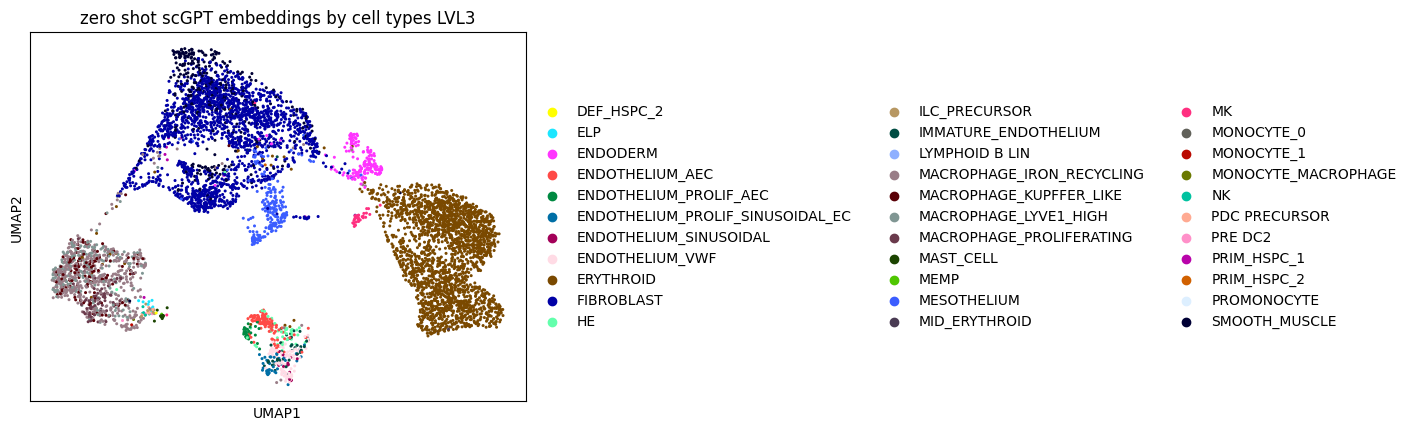

In [10]:
sc.pl.umap(test_dataset, color=["LVL3"], wspace = 0.6,title = "zero shot scGPT embeddings by cell types LVL3")

## Geneformer 33M


### Aplicado a Esclerosis Múltiple


In [5]:
geneformer_config = GeneformerConfig(batch_size=16, device=device, model_name="gf-12L-30M-i2048")
geneformer = Geneformer(configurer = geneformer_config)

data_geneformer = geneformer.process_data(data_enfermos, gene_names = "gene_name", use_raw_counts=False)
x_geneformer = geneformer.get_embeddings(data_geneformer)

INFO:helical.utils.downloader:Creating Folder /root/.cache/helical/models/geneformer/v1
INFO:helical.utils.downloader:File does not exist or has incorrect hash. Starting to download: 'https://helicalpackage.blob.core.windows.net/helicalpackage/data/geneformer/v1/gene_median_dictionary.pkl'
Downloading: 100%|██████████| 941k/941k [00:00<00:00, 1.26MB/s]
INFO:helical.utils.downloader:File saved to: '/root/.cache/helical/models/geneformer/v1/gene_median_dictionary.pkl'
INFO:helical.utils.downloader:File does not exist or has incorrect hash. Starting to download: 'https://helicalpackage.blob.core.windows.net/helicalpackage/data/geneformer/v1/token_dictionary.pkl'
Downloading: 100%|██████████| 788k/788k [00:00<00:00, 3.65MB/s]
INFO:helical.utils.downloader:File saved to: '/root/.cache/helical/models/geneformer/v1/token_dictionary.pkl'
INFO:helical.utils.downloader:File does not exist or has incorrect hash. Starting to download: 'https://helicalpackage.blob.core.windows.net/helicalpackage/da

Map:   0%|          | 0/13468 [00:00<?, ? examples/s]

INFO:helical.models.geneformer.model:Successfully processed the data for Geneformer.
INFO:helical.models.geneformer.model:Started getting embeddings:


  0%|          | 0/842 [00:00<?, ?it/s]

INFO:helical.models.geneformer.model:Finished getting embeddings.


In [6]:
embeddings_geneformer = ad.AnnData(X=x_geneformer)
data_enfermos.obsm["X_scGPT"] = embeddings_geneformer.X

sc.tl.pca(embeddings_geneformer)
data_enfermos.obsm["X_pca"] = embeddings_geneformer.obsm['X_pca']
data_enfermos.uns["pca"] = embeddings_geneformer.uns['pca']

sc.pp.neighbors(embeddings_geneformer, use_rep="X")
sc.tl.umap(embeddings_geneformer, random_state = 0)

data_enfermos.obsm["X_umap"] = embeddings_geneformer.obsm["X_umap"]
data_enfermos.uns["neighbors"] = embeddings_geneformer.uns['neighbors']
data_enfermos.obsp["distances"] = embeddings_geneformer.obsp['distances']
data_enfermos.obsp["connectivities"] = embeddings_geneformer.obsp['connectivities']

sc.tl.tsne(data_enfermos, use_rep = "X_pca", random_state = 0)

... storing 'ensembl_id' as categorical


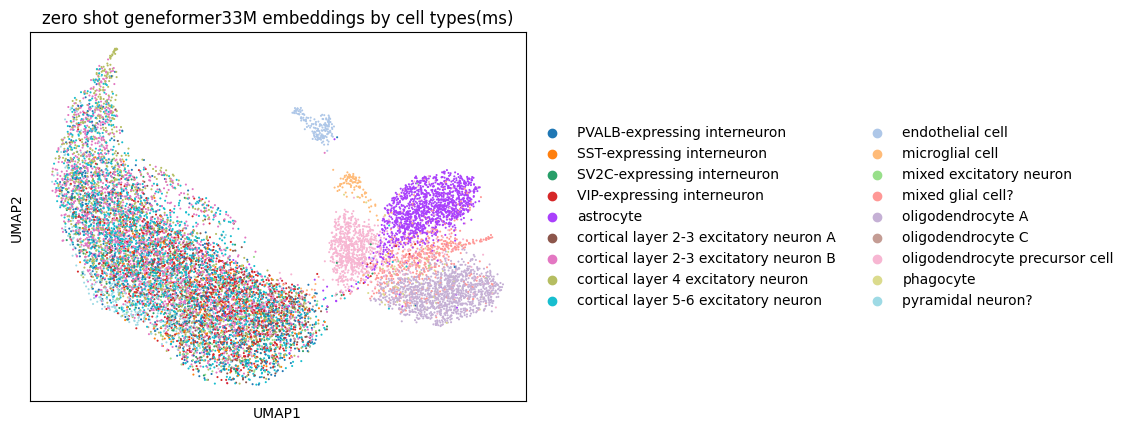

In [7]:
sc.pl.umap(data_enfermos, color=["celltype"], wspace = 0.6, title = "zero shot geneformer33M embeddings by cell types(ms)")

### Aplicado a datos helical

In [10]:
geneformer_config = GeneformerConfig(batch_size=16, device=device, model_name="gf-12L-30M-i2048")
geneformer = Geneformer(configurer = geneformer_config)

data_geneformer = geneformer.process_data(test_dataset, gene_names = "gene_name")
x_geneformer = geneformer.get_embeddings(data_geneformer)

INFO:helical.models.geneformer.model:Model finished initializing.
INFO:helical.models.geneformer.model:'gf-12L-30M-i2048' model is in 'eval' mode, on device 'cuda' with embedding mode 'cell'.
INFO:helical.models.geneformer.model:Processing data for Geneformer.
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.pep.all.fa.gz.pickle
INFO:helical.utils.mapping:Mapped 2791 genes to Ensembl IDs from a total of 3000 genes.
INFO:helical.models.geneformer.geneformer_tokenizer:AnnData object with n_obs × n_vars = 6336 × 3000
    obs: 'LVL1', 'LVL2', 'LVL3', 'total_counts'
    var: 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 

Map:   0%|          | 0/6336 [00:00<?, ? examples/s]

INFO:helical.models.geneformer.model:Successfully processed the data for Geneformer.
INFO:helical.models.geneformer.model:Started getting embeddings:


  0%|          | 0/396 [00:00<?, ?it/s]

INFO:helical.models.geneformer.model:Finished getting embeddings.


In [11]:
embeddings_geneformer = ad.AnnData(X=x_geneformer)
test_dataset.obsm["X_scGPT"] = embeddings_geneformer.X

sc.tl.pca(embeddings_geneformer)
test_dataset.obsm["X_pca"] = embeddings_geneformer.obsm['X_pca']
test_dataset.uns["pca"] = embeddings_geneformer.uns['pca']

sc.pp.neighbors(embeddings_geneformer, use_rep="X")
sc.tl.umap(embeddings_geneformer, random_state = 0)

test_dataset.obsm["X_umap"] = embeddings_geneformer.obsm["X_umap"]
test_dataset.uns["neighbors"] = embeddings_geneformer.uns['neighbors']
test_dataset.obsp["distances"] = embeddings_geneformer.obsp['distances']
test_dataset.obsp["connectivities"] = embeddings_geneformer.obsp['connectivities']

sc.tl.tsne(test_dataset, use_rep = "X_pca", random_state = 0)

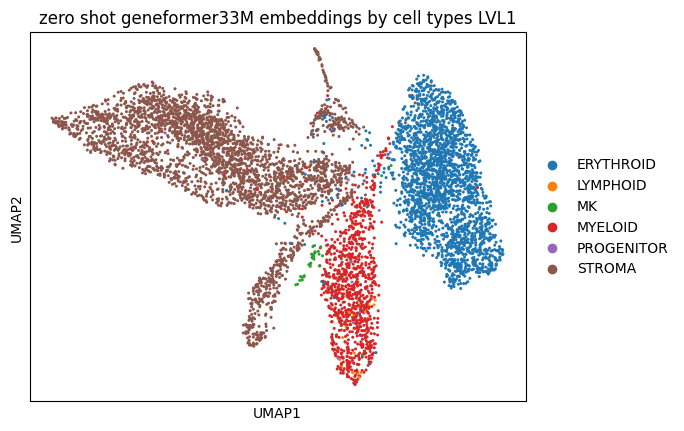

In [14]:
sc.pl.umap(test_dataset, color=["LVL1"], wspace = 0.6, title = "zero shot geneformer33M embeddings by cell types LVL1")

## CellPLM

In [1]:
!git clone https://github.com/OmicsML/CellPLM.git
%cd CellPLM
!pip install .
!pip install gdown

Cloning into 'CellPLM'...
remote: Enumerating objects: 156, done.
remote: Counting objects: 100% (156/156), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 156 (delta 59), reused 117 (delta 38), pack-reused 0 (from 0)
Receiving objects: 100% (156/156), 359.98 KiB | 4.00 MiB/s, done.
Resolving deltas: 100% (59/59), done.
/content/CellPLM
Processing /content/CellPLM
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.6/270.6 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.4 MB/s eta 0:00:

In [2]:
import hdf5plugin
import anndata as ad
import scanpy as sc
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from CellPLM.utils import set_seed
from CellPLM.pipeline.cell_embedding import CellEmbeddingPipeline
from CellPLM.pipeline.cell_type_annotation import CellTypeAnnotationPipeline, CellTypeAnnotationDefaultPipelineConfig, CellTypeAnnotationDefaultModelConfig
import gdown
import os
import numpy as np
import torch
from sklearn.model_selection import train_test_split

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
output_dir = "/content/CellPLM/ckpt/20230926_85M.best.ckpt"
file_id = "1IEoo_xPIpqnJluty2nQQVolb534KaWW3"

gdrive_url = f"https://drive.google.com/uc?id={file_id}"
gdown.download(gdrive_url, output=output_dir, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1IEoo_xPIpqnJluty2nQQVolb534KaWW3
From (redirected): https://drive.google.com/uc?id=1IEoo_xPIpqnJluty2nQQVolb534KaWW3&confirm=t&uuid=e1fed586-cda6-4f3d-87e3-698800288407
To: /content/CellPLM/ckpt/20230926_85M.best.ckpt
100%|██████████| 907M/907M [00:15<00:00, 57.3MB/s]


'/content/CellPLM/ckpt/20230926_85M.best.ckpt'

In [5]:
file_id = "19PYEpPeFm-YFlgD1459ms9j-TDhDja_W"

url = f"https://drive.google.com/uc?id={file_id}"

output_path = "/content/CellPLM/data"
gdown.download(url, output_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=19PYEpPeFm-YFlgD1459ms9j-TDhDja_W
From (redirected): https://drive.google.com/uc?id=19PYEpPeFm-YFlgD1459ms9j-TDhDja_W&confirm=t&uuid=61e3f0b3-5ef7-47e7-8e0f-e6d463fc06c9
To: /content/CellPLM/data
100%|██████████| 553M/553M [00:09<00:00, 56.9MB/s]


'/content/CellPLM/data'

Helical

In [7]:
ds = sc.read_h5ad("/content/CellPLM/data/datamgu6s9wl.part")


sc.pp.highly_variable_genes(ds, n_top_genes=3000, flavor='seurat_v3', inplace=True)
ds = ds[:, ds.var["highly_variable"]]


train1_ids, test_ids = train_test_split(
    np.arange(ds.n_obs), test_size=0.2, random_state=42
)

test_dataset = ds[test_ids].copy()

sc.pp.normalize_total(test_dataset)
sc.pp.log1p(test_dataset)

Esclerosis

In [13]:
output_dir = "../data/ms"
if os.path.exists(output_dir):

    print("data already downloaded!!")

else:

    folder_id = "1Qd42YNabzyr2pWt9xoY4cVMTAxsNBt4v"
    gdown.download_folder(f"https://drive.google.com/drive/folders/{folder_id}", output=output_dir, quiet=False)


data_enfermos = ad.read_h5ad(f'../data/ms/filtered_ms_adata.h5ad')

Retrieving folder contents


Processing file 1Vp51xYAOEu5_Wd7lilnatvMJ7tr2bsbl .DS_Store
Processing file 1bV1SHKVZgkcL-RmmuN51_IIUJTSJbXOi c_data.h5ad
Processing file 1casFhq4InuBNhJLMnGebzkRXM2UTTeQG filtered_ms_adata.h5ad


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1Vp51xYAOEu5_Wd7lilnatvMJ7tr2bsbl
To: /content/data/ms/.DS_Store
100%|██████████| 6.15k/6.15k [00:00<00:00, 13.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bV1SHKVZgkcL-RmmuN51_IIUJTSJbXOi
To: /content/data/ms/c_data.h5ad
100%|██████████| 20.6M/20.6M [00:00<00:00, 34.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1casFhq4InuBNhJLMnGebzkRXM2UTTeQG
To: /content/data/ms/filtered_ms_adata.h5ad
100%|██████████| 47.1M/47.1M [00:00<00:00, 190MB/s]
Download completed


### Aplicado a datos Esclerosis Múltiple

In [14]:
PRETRAIN_VERSION = '20230926_85M'
pipeline = CellEmbeddingPipeline(pretrain_prefix=PRETRAIN_VERSION, pretrain_directory='/content/CellPLM/ckpt')

embedding = pipeline.predict(data_enfermos, # An AnnData object
                device=device)

After filtering, 2763 genes remain.


/content/CellPLM/CellPLM/utils/data.py:81: UserWarning: Batch labels not found in AnnData.obs. All cells are considered from the same sample by default.
  warnings.warn(


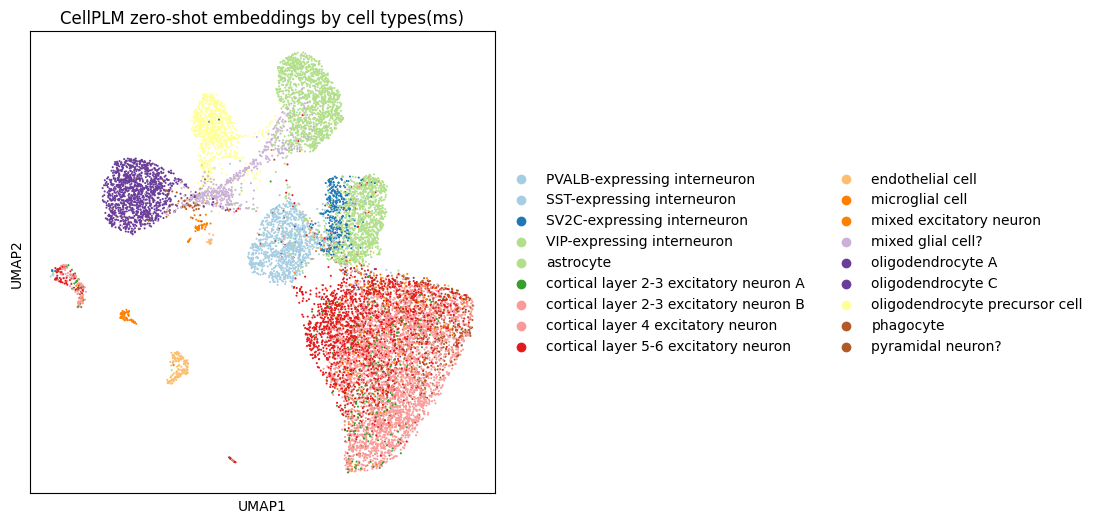

In [15]:
data_enfermos.obsm['emb'] = embedding.cpu().numpy()

sc.pp.neighbors(data_enfermos, use_rep='emb', method='umap')
sc.tl.umap(data_enfermos, random_state = 0)

plt.rcParams['figure.figsize'] = (6, 6)
sc.pl.umap(data_enfermos, color='celltype', palette='Paired', title='CellPLM zero-shot embeddings by cell types(ms)')

## Aplicado a datos Helical

In [8]:
PRETRAIN_VERSION = '20230926_85M'
pipeline = CellEmbeddingPipeline(pretrain_prefix=PRETRAIN_VERSION, pretrain_directory='/content/CellPLM/ckpt')

embedding = pipeline.predict(test_dataset, # An AnnData object
                device=device)

INFO:biothings.client:querying 1-1000 ...


Automatically converting gene symbols to ensembl ids...


INFO:biothings.client:querying 1001-2000 ...
INFO:biothings.client:querying 2001-3000 ...
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.
/content/CellPLM/CellPLM/utils/data.py:81: UserWarning: Batch labels not found in AnnData.obs. All cells are considered from the same sample by default.
  warnings.warn(
/content/CellPLM/CellPLM/utils/data.py:20: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  return torch.sparse_csr_tensor(x.indptr, x.indices, x.data, (x.shape[0], x.shape[1])).to_sparse().float().coalesce()


After filtering, 2484 genes remain.


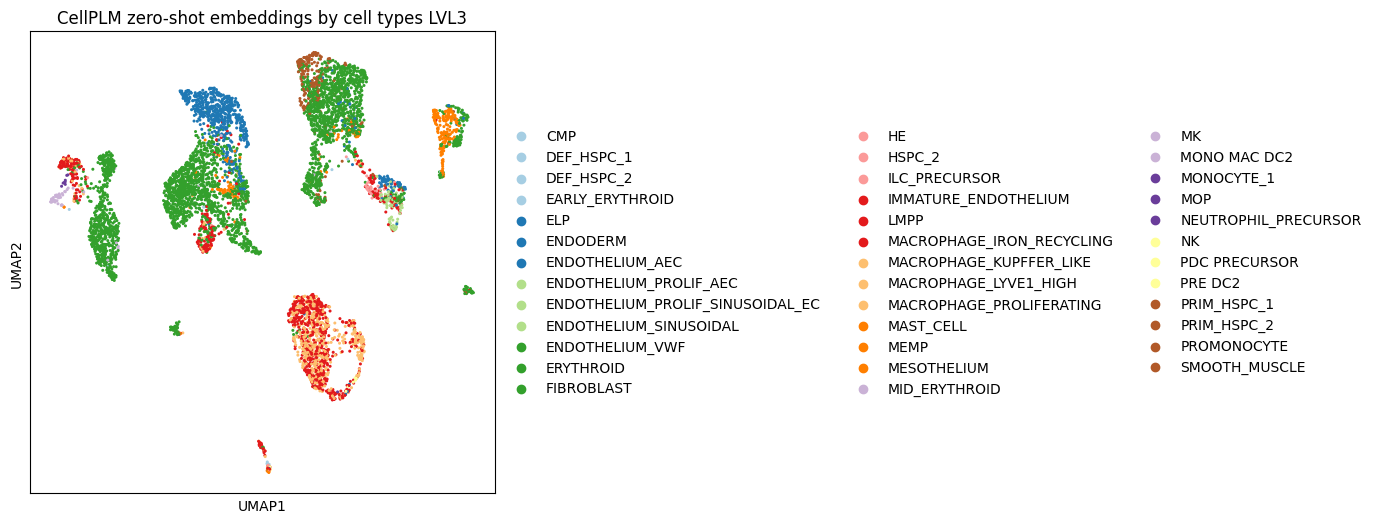

In [12]:
test_dataset.obsm['emb'] = embedding.cpu().numpy()

sc.pp.neighbors(test_dataset, use_rep='emb', method='umap')
sc.tl.umap(test_dataset, random_state = 0)

plt.rcParams['figure.figsize'] = (6, 6)
sc.pl.umap(test_dataset, color='LVL3', palette='Paired', title='CellPLM zero-shot embeddings by cell types LVL3')